# Run 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import joblib
from pickle import dump
from pandas import read_csv
from pickle import load

%matplotlib inline

In [2]:
from astroquery.ned import Ned
import astropy.units as u
from astropy import coordinates
from astropy.table import Table
import time
from astropy.coordinates import SkyCoord

In [3]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process.kernels import RBF

In [4]:
data_type = input('1: PCA\n 2: Scaled Data\n 3: Raw Data\n')

1: PCA
 2: Scaled Data
 3: Raw Data
1


# PCA & data scaling

In [5]:
df_training =  pd.read_csv("training_set_v1_dr7.csv")
columnsNamesArr = df_training.columns.values
column_names = list(columnsNamesArr)
print(column_names[1:])

['ra', 'dec', 'g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev', 'host_galaxy', 'distance', 'axis_ratio', 'category', 'radius', 'magnitude', 'u_mag', 'g_mag', 'i_mag', 'r_mag', 'z_mag', 'link']


In [6]:
print(df_training.groupby('category').size())


category
Contaminant       145
Known galaxies     18
dtype: int64


In [7]:
features = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev','axis_ratio','radius', 'magnitude']
print(len(features))

11


In [8]:
plt.rcParams.update({'font.size': 20})

<Figure size 720x576 with 0 Axes>

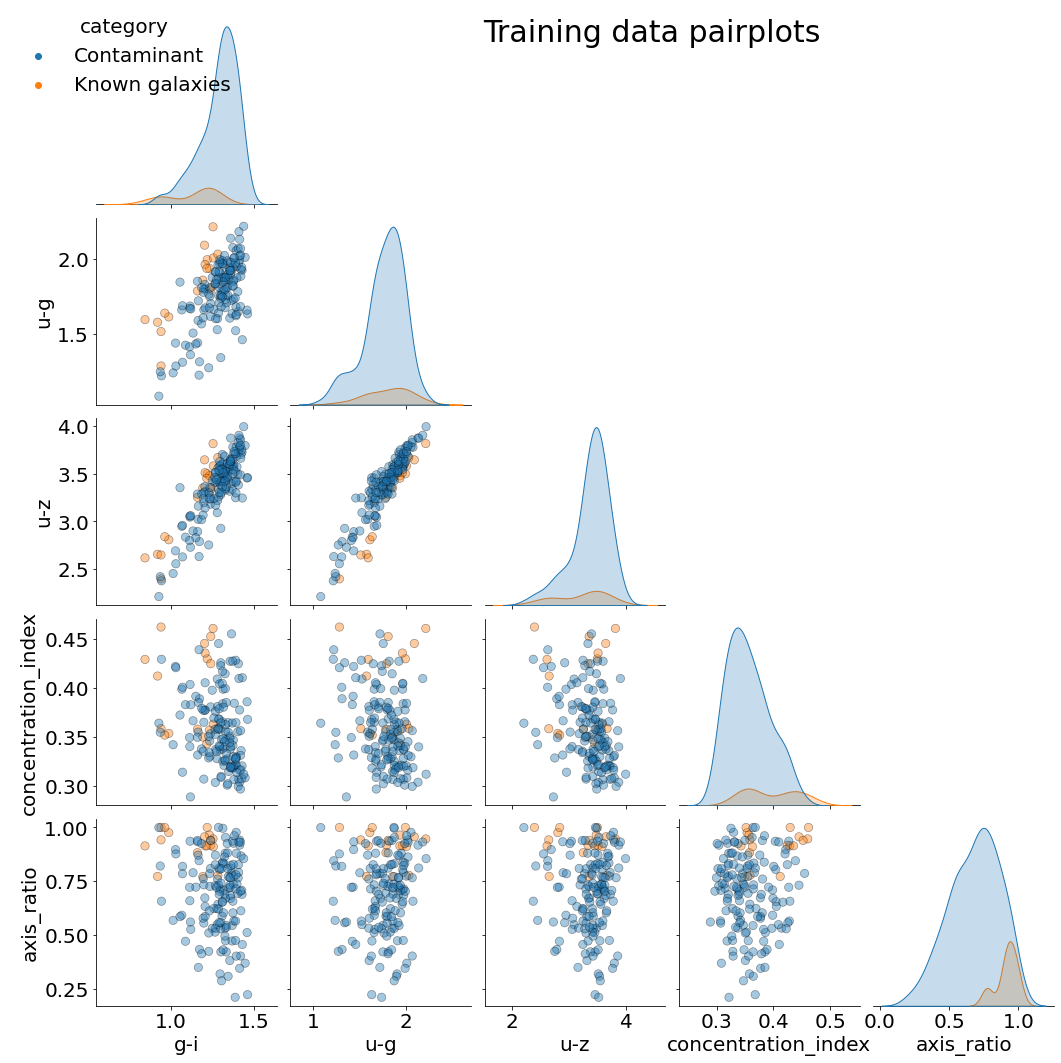

In [9]:
# %matplotlib qt
fig1 = plt.figure(figsize=(10,8))
# sns.set_context("paper", font_scale=2)
# sns.set(font_scale = 1.5)
ax = sns.pairplot(df_training, 
             vars = ['g-i', 'u-g', 'u-z', 'concentration_index','axis_ratio'],  hue="category",hue_order = ['Contaminant','Known galaxies'],
             corner=True,
             diag_kind = 'kde', 
             plot_kws = {'alpha': 0.4, 's': 70, 'edgecolor': 'k'},
             height=3);
# Title 
sns.move_legend(ax, "upper left")
plt.suptitle('Training data pairplots', 
             size = 30);
plt.savefig('pairplot_spec_dr7.png')

In [16]:
# classification as array of 0's and 1's
category = df_training['category']
classification = np.NaN*np.ones(len(category))
classification[category == 'Known galaxies'] = 1  
classification[category == 'Contaminant'] = 0 
print(len(classification))
print(len(classification[classification == 1]))

163
18


In [17]:
# define feature data and standardize it
data = df_training.loc[:,features].values
# define scaler
# scaler = StandardScaler()
scaler = RobustScaler()
# scaler = QuantileTransformer()
# fit scaler on the training dataset
scaler.fit(data)
# transform the training dataset
data_scaled = scaler.transform(data)

In [18]:
# transform data to 6 principle components which take into account 95 pct of the variance in the data
pca = PCA(n_components = 11, random_state = 2020)
pca.fit(data_scaled)
# pca = PCA(n_components = 0.95, random_state = 2020) this automatically chooses the amount of PC's for 95 pct variance
principal_components = pca.transform(data_scaled)
principal_df = pd.DataFrame(data = principal_components, columns = ['Principal Component 1','Principal Component 2','Principal Component 3','Principal Component 4','Principal Component 5','Principal Component 6','Principal Component 7','Principal Component 8','Principal Component 9','Principal Component 10','Principal Component 11'])
final_df = pd.concat([principal_df, df_training[['category']]], axis = 1)


Text(0.5, 1.0, 'Influence on each principal component by features')

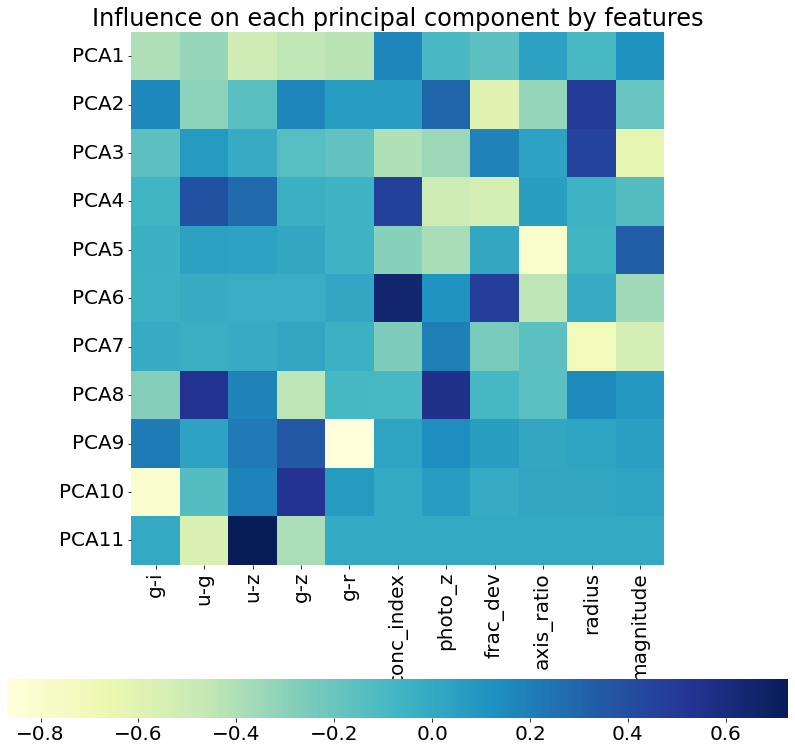

In [19]:
features_map = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'conc_index', 'photo_z', 'frac_dev', 'axis_ratio','radius', 'magnitude']
fig = plt.figure(figsize = (14,14))
ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=features_map,
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
ax.set_title('Influence on each principal component by features')

In [20]:
X = principal_components
y = classification

In [21]:
if data_type == 1:
    X = principal_components
    y = classification
elif data_type == 2:
    X = data_scaled
    y = classification
elif data_type == 3:
    X = data
    y = classification

In [22]:
# X = data_scaled
# y = classification

In [23]:
# X = data
# y = classification

In [24]:
# scorign to balanced accuracy
# test svm and plot corner plots showing where its failing and iterate through individual contaminants
# add new corner plots for new 45 galaxy
# try rescaling radius to kpc


# chheck for ways to reduce overfitting maxdepth in decision tree
# ned look at photoz with wise

# Model training

In [25]:
# Spot Check Algorithms
random_state = 2020
models = []
models.append(('LR', LogisticRegression(random_state = 2020,solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state = 2020,gamma='auto')))
models.append(('GP', GaussianProcessClassifier(random_state = 2020)))
models.append(('RF', RandomForestClassifier(random_state = 2020,max_depth=None, n_estimators=100, max_features= 'auto')))
models.append(('MLP', MLPClassifier(random_state = 2020,activation='relu', solver='lbfgs', max_iter=200)))
models.append(('PRCP', Perceptron(random_state = 2020, max_iter=30, tol = 0.001)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=4, random_state=2020, shuffle=True)
	cv_results = cross_val_score(model, X, y, cv=kfold, scoring='recall')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# try neural network

LR: 0.887500 (0.113880)
LDA: 0.612500 (0.387903)
KNN: 0.550000 (0.150000)
CART: 0.675000 (0.238485)
NB: 0.550000 (0.337268)
SVM: 0.837500 (0.170935)
GP: 0.775000 (0.178536)
RF: 0.550000 (0.231840)
MLP: 0.937500 (0.108253)
PRCP: 0.712500 (0.313000)


In [26]:
# voting methods application
clf1 = LogisticRegression(random_state = 2020,solver='liblinear', multi_class='ovr')
clf2 = LinearDiscriminantAnalysis()
clf3 = KNeighborsClassifier()
clf4 = DecisionTreeClassifier()
clf5 = GaussianNB()
clf6 = GaussianProcessClassifier(random_state = 2020)
clf7 = SVC(random_state = 2020,gamma='auto')
clf8 = RandomForestClassifier(random_state = 2020,max_depth=None, n_estimators=100, max_features= 'auto')
clf9 = MLPClassifier(random_state = 2020, activation='relu', solver='lbfgs', max_iter=100000)
clf10 = Perceptron(random_state = 2020, max_iter=30, tol = 0.001)

eclf1 = VotingClassifier(estimators=[('SVM', clf7),('LR',clf1),('CART', clf4), ('GP', clf6), ('MLP', clf9), ('LDA',clf2)], voting='hard')
eclf1.fit(X, y)
eclf_predict = eclf1.predict(X)

In [27]:
# # save the model
# dump(eclf1, open('voting_model_PCA_v1_dr7.pkl', 'wb'))
# # save the scaler
# dump(scaler, open('scaler_voting_model_PCA_v1_dr7.pkl', 'wb'))
# # save the pca
# dump(pca, open('pca_model_PCA_v1_dr7.pkl', 'wb'))

In [28]:
plt.rcParams.update({'font.size': 20})

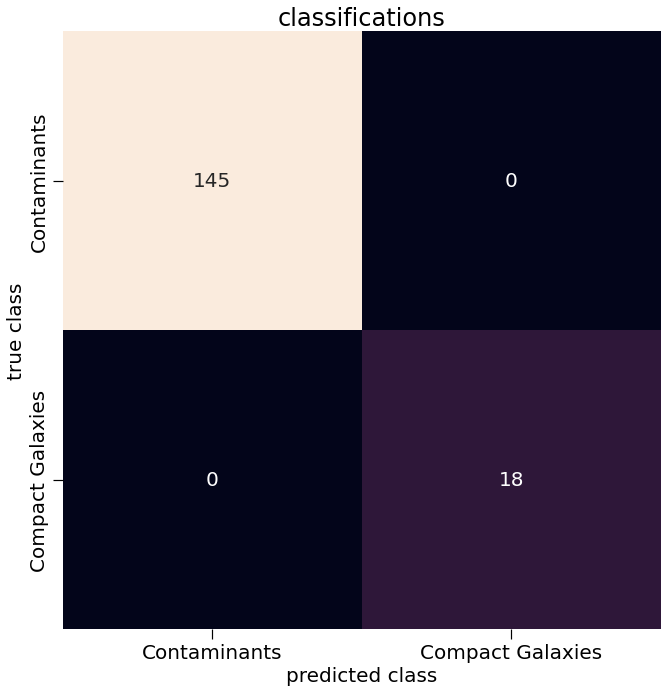

In [30]:
fig1 = plt.figure(figsize=(11,11))
g = sns.heatmap(confusion_matrix(y, eclf_predict), square=True, annot=True, fmt="d", cbar=False, xticklabels=['Contaminants', 'Compact Galaxies'], yticklabels=['Contaminants', 'Compact Galaxies'])
g.set_yticklabels(labels=g.get_yticklabels(), va='center')
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.title('classifications')
plt.tick_params('both', length=10, width=1.2, which='major', labelsize=20)
plt.savefig('confusion_matrix.png')

# Model application on Atlas3D galaxies

In [22]:
df_atlas3d = pd.read_csv("atlas3d_search_dr7.csv")
columnsNamesArr = df_atlas3d.columns.values
column_names = list(columnsNamesArr)
print(column_names[1:])

['objid', 'ra', 'dec', 'g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev', 'host_galaxy', 'distance', 'axis_ratio', 'category', 'radius', 'magnitude', 'u_mag', 'g_mag', 'i_mag', 'r_mag', 'z_mag', 'link']


In [23]:
objid = df_atlas3d['objid']
ra, dec = df_atlas3d['ra'], df_atlas3d['dec']
host_galaxy = df_atlas3d['host_galaxy']
distance = df_atlas3d['distance']
magnitude = df_atlas3d['magnitude']
category = df_atlas3d['category']
radius = df_atlas3d['radius']
u_mag, g_mag, r_mag, i_mag, z_mag = df_atlas3d['u_mag'], df_atlas3d['g_mag'], df_atlas3d['r_mag'], df_atlas3d['i_mag'], df_atlas3d['z_mag']
concentration_index = df_atlas3d['concentration_index']
frac_dev = df_atlas3d['frac_dev']
axis_ratio = df_atlas3d['axis_ratio']
photoz = df_atlas3d['photo_z']
category = df_atlas3d['category']
g_i, u_g, u_z, g_z, g_r = df_atlas3d['g-i'], df_atlas3d['u-g'], df_atlas3d['u-z'], df_atlas3d['g-z'], df_atlas3d['g-r']
magnitude = df_atlas3d['magnitude']
radius = df_atlas3d['radius']

In [24]:
category[category == 'Possible contaminants'] = 'Possible compact galaxies'

C:\Users\Home\AppData\Local\Temp/ipykernel_18084/2455194359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category[category == 'Possible contaminants'] = 'Possible compact galaxies'


In [25]:
features = ['g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'concentration_index', 'photo_z', 'frac_dev','axis_ratio','radius', 'magnitude']
print(len(features))

11


In [26]:
#make a link to sdss for this object
objid = np.array(objid)
link = []
for i in range(len(objid)):
    url = 'http://cas.sdss.org/dr7/en/tools/explore/obj.asp?id=' + str(objid[i])
    link.append(url)
link = np.array(link)

In [27]:
print(df_atlas3d.groupby('category').size())

category
Known galaxies                  18
Possible compact galaxies    18769
dtype: int64


In [28]:
#PCA
X = df_atlas3d.loc[:,features].values
X_scaled = scaler.transform(X)
X_pca_scaled = pca.transform(X_scaled)
y = eclf1.predict(X_pca_scaled) 

In [29]:
# #Scaled
# X = df_atlas3d.loc[:,features].values
# X_scaled = scaler.transform(X)
# # X_pca_scaled = pca.transform(X_scaled)
# y = eclf1.predict(X_scaled) 

In [30]:
# #Raw
# X = df_atlas3d.loc[:,features].values
# # X_scaled = scaler.transform(X)
# # X_pca_scaled = pca.transform(X_scaled)
# y = eclf1.predict(X) 

In [31]:
index_1a = np.where(y == 1)[0]
print('Voting method:', len(index_1a))
index_1b = np.where(y == 0)[0]

Voting method: 386


In [32]:
# dictionary of lists  
dict = {'objid': objid[index_1a], 'ra': ra[index_1a], 'dec': dec[index_1a], 'g-i': g_mag[index_1a] - i_mag[index_1a], 'u-g': u_mag[index_1a] - g_mag[index_1a], 'u-z': u_mag[index_1a] - z_mag[index_1a], 'g-z': g_mag[index_1a] - z_mag[index_1a], 'g-r': g_mag[index_1a] - r_mag[index_1a], 'concentration_index': concentration_index[index_1a], 'photo_z': photoz[index_1a], 'frac_dev': frac_dev[index_1a], 'host_galaxy': host_galaxy[index_1a], 'distance': distance[index_1a], 'axis_ratio': axis_ratio[index_1a], 'category': category[index_1a], 'radius': radius[index_1a], 'magnitude': magnitude[index_1a], 'u_mag': u_mag[index_1a], 'g_mag': g_mag[index_1a], 'i_mag': i_mag[index_1a], 'r_mag': r_mag[index_1a], 'z_mag': z_mag[index_1a],  'link': link[index_1a]}   
df_voting_results= pd.DataFrame(dict) 
    
# saving the dataframe 
df_voting_results.to_csv('voting_results_v1.csv',index = False) 

In [33]:
print(df_voting_results.groupby('category').size())
print('From a total of 871 host galaxies')

category
Known galaxies                18
Possible compact galaxies    368
dtype: int64
From a total of 871 host galaxies


# NED search for possible compact galaxies from 

In [34]:
objid_voting = df_voting_results['objid']
ra_voting, dec_voting = np.array(df_voting_results['ra']), np.array(df_voting_results['dec'])
host_galaxy_voting = df_voting_results['host_galaxy']
distance_voting = df_voting_results['distance']
magnitude_voting = df_voting_results['magnitude']
category_voting = df_voting_results['category']
radius_voting = df_voting_results['radius']
u_mag_voting, g_mag_voting, r_mag_voting, i_mag_voting, z_mag_voting = df_voting_results['u_mag'], df_voting_results['g_mag'], df_voting_results['r_mag'], df_voting_results['i_mag'], df_voting_results['z_mag']
concentration_index_voting = df_voting_results['concentration_index']
frac_dev_voting = df_voting_results['frac_dev']
axis_ratio_voting = df_voting_results['axis_ratio']
photoz_voting = df_voting_results['photo_z']
category_voting = df_voting_results['category']
g_i_voting, u_g_voting, u_z_voting, g_z_voting, g_r_voting = df_voting_results['g-i'], df_voting_results['u-g'], df_voting_results['u-z'], df_voting_results['g-z'], df_voting_results['g-r']
link_voting = df_voting_results['link']

In [35]:
name1 = []
ra1 = []
dec1 = []
velocity1 = []
redshift1 = []
flag1 = []
for i in range(len(ra_voting)):
    print(i)
#     if i%200 == 0:
#         time.sleep(15)
    co = coordinates.SkyCoord(ra=ra_voting[i], dec=dec_voting[i], unit=(u.deg, u.deg))
    results = Ned.query_region(co, radius=1* u.arcsec, equinox='J2000.0')
    if len(results) == 0:
        name1_temp, ra1_temp, dec1_temp, vel1_temp, redshift1_temp, flag1_temp = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        name1.append(name1_temp)
        ra1.append(ra1_temp)
        dec1.append(dec1_temp)
        velocity1.append(vel1_temp)
        redshift1.append(redshift1_temp)
        flag1.append(flag1_temp)
    else:
        name1_temp, ra1_temp, dec1_temp, vel1_temp, redshift1_temp, flag1_temp = results['Object Name'], results['RA'], results['DEC'], results['Velocity'], results['Redshift'], results['Redshift Flag']
        for j in range(len(name1_temp)):
            name1.append(name1_temp[j])
            ra1.append(ra1_temp[j])
            dec1.append(dec1_temp[j])
            velocity1.append(vel1_temp[j])
            redshift1.append(redshift1_temp[j])
            flag1.append(flag1_temp[j])

0
1


2
3
4
5
6
7


WARNING

8


: AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead. [astroquery.ned.core]


9
10
11
12
13
14


15
16
17
18
19
20
21
22
23
24
25


26
27
28
29
30


31
32
33
34
35
36


37
38
39
40
41
42


43
44
45
46
47


48
49
50
51
52
53
54
55
56


57
58
59
60
61
62
63
64


65
66
67
68
69
70
71


72
73
74
75
76
77


78
79
80
81
82
83
84


85
86
87
88
89


90
91
92
93
94


95
96
97
98
99


100
101
102
103
104
105
106
107
108
109


110
111
112
113
114
115
116
117
118
119
120
121
122
123


124
125
126
127
128
129
130
131
132


133
134
135
136
137
138
139


140
141
142
143
144
145
146
147


148
149
150
151
152
153
154
155

WARNING


156
157
158
159
160


: AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead. [astroquery.ned.core]


161
162
163
164


165
166
167
168
169
170
171
172
173


174
175
176
177
178
179
180
181


182
183
184
185
186


187
188
189


190
191
192
193
194


195
196
197
198
199
200
201
202
203
204


205
206
207
208
209
210
211


212
213


WARNING

214
215
216
217
218


: AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead. [astroquery.ned.core]


219
220
221
222
223
224
225


226
227
228
229
230


WARNING

231
232
233
234
235
236


: AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead. [astroquery.ned.core]


237
238
239
240
241
242


243
244
245
246
247


248
249
250
251
252
253
254
255


256
257
258
259
260
261
262
263

WARNING


264
265
266


: AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead. [astroquery.ned.core]


267
268
269
270
271


272
273
274
275
276
277


WARNING

278
279
280
281
282
283


: AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead. [astroquery.ned.core]


284
285
286
287
288
289


290
291
292
293
294
295
296


297
298
299
300
301


302
303
304
305
306
307


308
309
310
311
312


313
314
315
316
317


318
319
320
321
322
323
324
325
326
327
328
329


330
331
332
333
334
335


336
337
338
339


340
341
342
343
344


345
346
347



WARNING

348


: AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead. [astroquery.ned.core]


349
350
351


352
353
354
355
356
357


358
359
360
361


362
363
364
365
366
367


368
369
370
371
372
373


374
375
376
377


378
379
380
381
382
383
384
385


In [36]:
# dictionary of lists  
dict = {'name': name1, 'ra': ra1, 'dec': dec1, 'velocity': velocity1, 'redshift': redshift1, 'flag': flag1}  
df_ned_voting = pd.DataFrame(dict) 
    
# saving the dataframe 
# df1.to_csv('ned_compact_dr7.csv') 

# NED (with specz > 0.01) and ML results crossmatching

In [37]:
ra_ned_voting, dec_ned_voting, name_ned_voting, velocity_ned_voting, redshift_ned_voting, flag_ned_voting = df_ned_voting['ra'], df_ned_voting['dec'], df_ned_voting['name'], df_ned_voting['velocity'], df_ned_voting['redshift'], df_ned_voting['flag']

In [38]:
redshift_ned_voting_1a = redshift_ned_voting.copy()
redshift_ned_voting_1a[redshift_ned_voting_1a == '--'] = np.nan
redshift_ned_voting_1a = redshift_ned_voting_1a.astype(float)

voting_specz_over = (redshift_ned_voting_1a > 0.01) & (flag_ned_voting == 'SPEC')

C:\Users\Home\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1201: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [39]:
ra_ned_voting_1 = np.array(ra_ned_voting[voting_specz_over])
dec_ned_voting_1 = np.array(dec_ned_voting[voting_specz_over])
name_ned_voting_1 =  np.array(name_ned_voting[voting_specz_over])
velocity_ned_voting_1 = np.array(velocity_ned_voting[voting_specz_over])
redshift_ned_voting_1 = np.array(redshift_ned_voting[voting_specz_over]).astype(float)
flag_ned_voting_1 = np.array(flag_ned_voting[voting_specz_over])

In [40]:
c1 = SkyCoord(ra=ra_voting*u.degree, dec=dec_voting*u.degree)
catalog1 = SkyCoord(ra=ra_ned_voting_1*u.degree, dec=dec_ned_voting_1*u.degree)
idx_1, d2d_1, d3d_1 = c1.match_to_catalog_sky(catalog1)

In [41]:
max_sep = 1 * u.arcsec
sep_constraint_1 = d2d_1 < max_sep
c1_matches = c1[sep_constraint_1]
catalog1_matches = catalog1[idx_1[sep_constraint_1]]

In [42]:
objid_training = df_training['objid']
ra_training, dec_training = df_training['ra'], df_training['dec']
host_galaxy_training = df_training['host_galaxy']
distance_training = df_training['distance']
magnitude_training = df_training['magnitude']
category_training = df_training['category']
radius_training = df_training['radius']
u_mag_training, g_mag_training, r_mag_training, i_mag_training, z_mag_training = df_training['u_mag'], df_training['g_mag'], df_training['r_mag'], df_training['i_mag'], df_training['z_mag']
concentration_index_training = df_training['concentration_index']
frac_dev_training = df_training['frac_dev']
axis_ratio_training = df_training['axis_ratio']
photoz_training = df_training['photo_z']
category_training = df_training['category']
g_i_training, u_g_training, u_z_training, g_z_training, g_r_training = df_training['g-i'], df_training['u-g'], df_training['u-z'], df_training['g-z'], df_training['g-r']
link_training = df_training['link']

In [43]:
category_voting[sep_constraint_1] = 'Contaminant'

C:\Users\Home\AppData\Local\Temp/ipykernel_18084/354860432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_voting[sep_constraint_1] = 'Contaminant'


# Creating new training data:
## Adding original training set + NED confirmed contaminants

In [44]:
objid_final = np.concatenate((objid_training,objid_voting[sep_constraint_1]))
ra_final, dec_final = np.concatenate((ra_training,ra_voting[sep_constraint_1])), np.concatenate((dec_training,dec_voting[sep_constraint_1]))
host_galaxy_final = np.concatenate((host_galaxy_training,host_galaxy_voting[sep_constraint_1]))
distance_final = np.concatenate((distance_training,distance_voting[sep_constraint_1]))
magnitude_final = np.concatenate((magnitude_training,magnitude_voting[sep_constraint_1]))
category_final = np.concatenate((category_training,category_voting[sep_constraint_1]))
radius_final = np.concatenate((radius_training,radius_voting[sep_constraint_1]))
u_mag_final, g_mag_final, r_mag_final, i_mag_final, z_mag_final = np.concatenate((u_mag_training,u_mag_voting[sep_constraint_1])), np.concatenate((g_mag_training,g_mag_voting[sep_constraint_1])), np.concatenate((r_mag_training,r_mag_voting[sep_constraint_1])), np.concatenate((i_mag_training,i_mag_voting[sep_constraint_1])), np.concatenate((z_mag_training,z_mag_voting[sep_constraint_1]))
concentration_index_final = np.concatenate((concentration_index_training,concentration_index_voting[sep_constraint_1]))
frac_dev_final = np.concatenate((frac_dev_training,frac_dev_voting[sep_constraint_1]))
axis_ratio_final = np.concatenate((axis_ratio_training,axis_ratio_voting[sep_constraint_1]))
photoz_final = np.concatenate((photoz_training,photoz_voting[sep_constraint_1]))
category_final = np.concatenate((category_training,category_voting[sep_constraint_1]))
g_i_final, u_g_final, u_z_final, g_z_final, g_r_final = np.concatenate((g_i_training,g_i_voting[sep_constraint_1])), np.concatenate((u_g_training,u_g_voting[sep_constraint_1])), np.concatenate((u_z_training,u_z_voting[sep_constraint_1])), np.concatenate((g_z_training,g_z_voting[sep_constraint_1])), np.concatenate((g_r_training,g_r_voting[sep_constraint_1]))
link_final = np.concatenate((link_training,link_voting[sep_constraint_1]))

In [45]:
# dictionary of lists  
dict = {'objid': objid_final, 'ra': ra_final, 'dec': dec_final, 'g-i': g_i_final, 'u-g': u_g_final, 'u-z': u_z_final, 'g-z': g_z_final, 'g-r': g_r_final, 'concentration_index': concentration_index_final, 'photo_z': photoz_final, 'frac_dev': frac_dev_final, 'host_galaxy': host_galaxy_final, 'distance': distance_final, 'axis_ratio': axis_ratio_final, 'category': category_final, 'radius': radius_final, 'magnitude': magnitude_final, 'u_mag': u_mag_final, 'g_mag': g_mag_final, 'i_mag': i_mag_final, 'r_mag': r_mag_final, 'z_mag': z_mag_final,  'link': link_final}  
df_training_v2 = pd.DataFrame(dict) 
    
# saving the dataframe 
df_training_v2.to_csv('training_v2_dr7.csv') 

In [46]:
print(df_training_v2 .groupby('category').size())

category
Contaminant       189
Known galaxies     18
dtype: int64
